#### Tandem model using detect and classify models from Yu, et al
Tandem inference implementation of the detection and classification model from the Yu, et al [paper](https://drive.google.com/file/d/1nYl4w41CAcj8XwTEdVwcD5lVheUFIHVy/view?usp=sharing)

Uses data resized to 60x60 with n=2 morphological thinning.

In [1]:
!pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers, callbacks

import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
tf.__version__

'2.3.4'

In [4]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# specify variables
path = 'processed_data/WM-clean60-thin2'
result_path = 'results'

filename = 'WM-clean60-thin2'
map_column = 'thinMap2'

model_id = 'yutandem'
data_id = '60'
note = '-thin2' # -optional

detect_model = 'yudetect-60-thin2'
classify_model = 'yuclassify-60-thin2'

In [6]:
# load test set(s) to be used
# directly from S3 (using boto3 resource)
start = time.time()

test_key = f'{path}/{filename}-test.pkl'
test = pickle.loads(my_bucket.Object(test_key).get()['Body'].read())

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Test: {len(test)}")

Wall time: 1.97 seconds
Test: 25943


#### Quick EDA

In [7]:
# baseline accuracy of test set
nones = len(test[test.detectLabels == 0])
total = len(test)
print(f"Baseline accuracy: {nones/total*100:.2f}%")

Baseline accuracy: 85.24%


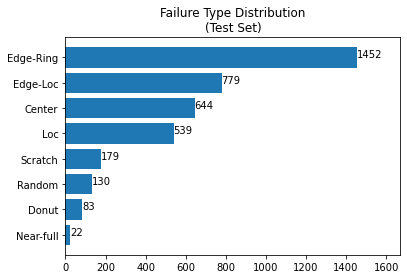

In [8]:
# test failure type distribution
test_defects = test[test.detectLabels == 1]
helper.defect_distribution(test_defects, note='Test Set')

#### Detect Model

##### Detect data set-up

In [9]:
# prepare inputs
start = time.time()

x_det = np.stack(test[map_column])
x_det = tf.expand_dims(x_det, axis=3, name=None)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_det.shape

Wall time: 1.10 seconds


TensorShape([25943, 60, 60, 1])

In [10]:
# prepare labels for evaluating results
start = time.time()

y_det = np.asarray(test['detectLabels']).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 0.00 seconds


##### Load and run detect model

In [11]:
# load saved detect model from S3
start = time.time()

detect = s3_get_keras_model(detect_model)
detect.summary()

print("Wall time: {:.2f} seconds".format(time.time() - start))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0

In [12]:
# generate predictions
start = time.time()

detect_pred = detect.predict(x_det)
det_labels = np.argmax(detect_pred, axis=1).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 9.34 seconds


In [13]:
# manually compute accuracy
# model.evaluate() doesn't work
det_cm = confusion_matrix(y_det, det_labels)
det_accuracy = (det_cm[0][0] + det_cm[1][1]) / len(y_det) * 100
print(f'Detection Model Accuracy: {det_accuracy:.2f}%')

Detection Model Accuracy: 95.65%


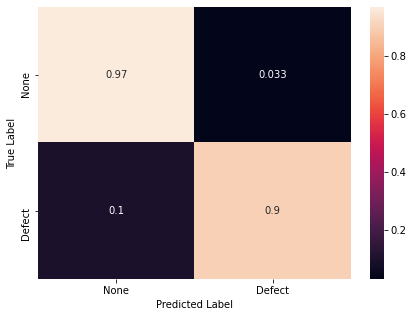

In [14]:
helper.plot_confusion_matrix(y_det, det_labels, mode='detect', normalize=True)

#### Classify Model

##### Classify data set-up

In [15]:
# keep only subset of test data
# predicted by detect model as having defects
defect_indices = [i for i in range(len(det_labels)) if det_labels[i] == 1]
defect_ids = [test.ID[i] for i in defect_indices]
defect_df = test.loc[defect_indices].reset_index(drop=True)

# sanity check:
print(f'{len(defect_indices)}, {len(defect_ids)}, {defect_df.shape}')

4173, 4173, (4173, 4)


In [16]:
# prepare inputs
start = time.time()

x_cls = np.stack(defect_df[map_column])
x_cls = tf.expand_dims(x_cls, axis=3, name=None)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_det.shape

Wall time: 0.03 seconds


TensorShape([25943, 60, 60, 1])

In [17]:
# prepare labels for evaluating results
start = time.time()

y_cls = np.asarray(defect_df['classifyLabels']).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 0.00 seconds


##### Load and run classify model

In [18]:
# load saved classify model from S3
start = time.time()

classify = s3_get_keras_model(classify_model)
classify.summary()

print("Wall time: {:.2f} seconds".format(time.time() - start))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 224, 224, 1)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 1)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        1

In [19]:
# generate predictions
start = time.time()

classify_pred = classify.predict(x_cls)
cls_labels = np.argmax(classify_pred, axis=1).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 2.97 seconds


#### Tandem model results

In [20]:
# generate full prediction
def tandem_prediction(x):
    if x in set(defect_ids):
        i = defect_ids.index(x)
        return cls_labels[i]
    else:
        return 8

test['tandemLabels'] = test.ID.apply(lambda x: tandem_prediction(x))
tandem_pred = test['tandemLabels'].tolist()
print(len(tandem_pred))

25943


In [21]:
# save predictions to local instance
predictions = [defect_ids, detect_pred, classify_pred, tandem_pred]
with open(f'{result_path}/{model_id}-{data_id}{note}.pkl', "wb") as f:
    pickle.dump(predictions, f)

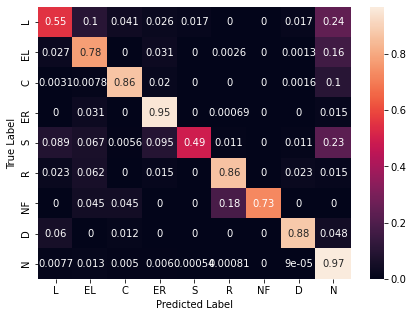

In [22]:
# plot confusion matrix
y_test = test['classifyLabels'].tolist()
helper.plot_confusion_matrix(y_test, tandem_pred, mode='all', normalize=True)

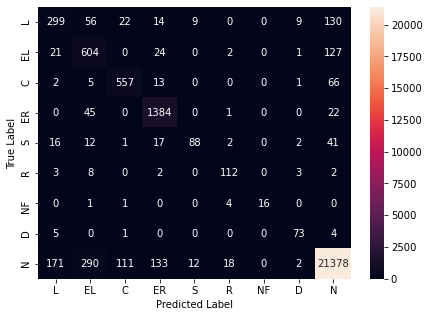

In [23]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, tandem_pred, mode='all', normalize=False)

In [24]:
# manually compute overall accuracy
tandem_cm = confusion_matrix(y_test, tandem_pred)

tandem_num = 0
for i in range(9):
    tandem_num += tandem_cm[i][i]

overall_accuracy = tandem_num / len(y_test) * 100
print(f'Overall Model Accuracy: {overall_accuracy:.2f}%') 

Overall Model Accuracy: 94.48%
